# Partition SBM Baseline Code

## Doc string

In [1]:
#!/usr/bin/env python

#
# Copyright 2017 MIT Lincoln Laboratory, Massachusetts Institute of Technology
#
# Licensed under the Apache License, Version 2.0 (the "License"); you may not use these files except in compliance with
# the License.
#
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on
# an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the
# specific language governing permissions and limitations under the License.
#

"""
Authors: Steven Smith, Edward Kao
Date: 9 January 2017
Installation: Python 2.7

Description: This Python script performs the baseline graph partition algorithm based on the degree-corrected stochastic block model.

References:
Peixoto, Tiago P. "Entropy of stochastic blockmodel ensembles." Physical Review E 85, no. 5 (2012): 056122.
Peixoto, Tiago P. "Parsimonious module inference in large networks." Physical review letters 110, no. 14 (2013): 148701.
Karrer, Brian, and Mark EJ Newman. "Stochastic blockmodels and community structure in networks." Physical Review E 83, no. 1 (2011): 016107.
"""

'\nAuthors: Steven Smith, Edward Kao\nDate: 9 January 2017\nInstallation: Python 2.7\n\nDescription: This Python script performs the baseline graph partition algorithm based on the degree-corrected stochastic block model.\n\nReferences:\nPeixoto, Tiago P. "Entropy of stochastic blockmodel ensembles." Physical Review E 85, no. 5 (2012): 056122.\nPeixoto, Tiago P. "Parsimonious module inference in large networks." Physical review letters 110, no. 14 (2013): 148701.\nKarrer, Brian, and Mark EJ Newman. "Stochastic blockmodels and community structure in networks." Physical Review E 83, no. 1 (2011): 016107.\n'

## Dependencies

In [21]:
import pandas as pd # for loading input graph TSV files
import sys
import numpy as np
from scipy import sparse as sparse
import scipy.misc as misc
from munkres import Munkres # for correctness evaluation

use_timeit = True # for timing runs (optional)
if use_timeit:
    import timeit 

use_graph_tool_options = True # for visualiziing graph partitions (optional)
if use_graph_tool_options:
    import graph_tool.all as gt


## Graph data structure

A graph is represented as a list of numpy arrays. Each element in the outer array represents the array of vertex neighbors, and each row in the inner arrays has three values representing a directed edge betwee the neighbors (from, to) with edge weight (default to 1). 

A vertex label hash is stored from the input triple store file format. Vertices are internally indexed by an integer value from 0 to *N*&ndash;1, where *N* is the number of vertices.

The truth and output partitions are stored as numpy arrays.

# Supporting functions

## Load the graph from standard TSV files, and the truth partition if available

The tsv file is assumed to be of the form "from to [weight]" (tab delimited). If available, the true partition is assumed to be stored in the file `filename_truePartition.tsv`. Nodes are assumed to be indexed from *0* to *N-1* in the input file.
### Parameters
    input_filename : str
            input file name not including the .tsv extension
    true_partition_available : bool
            whether the truth partition is available
### Returns
    out_neighbors : list of ndarray; list length is N, the number of nodes
            each element of the list is a ndarray of out neighbors, where the first column is the node indices
            and the second column the corresponding edge weights
    in_neighbors : list of ndarray; list length is N, the number of nodes
            each element of the list is a ndarray of in neighbors, where the first column is the node indices
            and the second column the corresponding edge weights
    N : int
            number of nodes in the graph
    E : int
            number of edges in the graph
    true_b : ndarray (int) optional
            array of truth block assignment for each node

In [3]:
def load_graph(input_filename, true_partition_available):
    # read the entire graph CSV into rows of edges
    edge_rows = pd.read_csv('{}.tsv'.format(input_filename), delimiter='\t').as_matrix()
    N = edge_rows[:, 0:1].max() + 1
    out_neighbors = [[] for i in range(N)]
    in_neighbors = [[] for i in range(N)]
    weights_included = edge_rows.shape[1] == 3

    # load edges to list of lists of out and in neighbors
    for i in range(edge_rows.shape[0]):
        if weights_included:
            edge_weight = edge_rows[i, 2]
        else:
            edge_weight = 1
        out_neighbors[edge_rows[i, 0]].append([edge_rows[i, 1], edge_weight])
        in_neighbors[edge_rows[i, 1]].append([edge_rows[i, 0], edge_weight])

    # convert each neighbor list to neighbor numpy arrays for faster access
    for i in range(N):
        out_neighbors[i] = np.array(out_neighbors[i], dtype=int)
    for i in range(N):
        in_neighbors[i] = np.array(in_neighbors[i], dtype=int)

    # find number of nodes and edges
    N = len(out_neighbors)
    E = sum([len(v) for v in out_neighbors])

    if true_partition_available:
        true_b = np.zeros(len(out_neighbors), dtype=int)
        # read the entire true partition CSV into rows of partitions
        true_b_rows = pd.read_csv('{}_truePartition.tsv'.format(input_filename), delimiter='\t').as_matrix()
        for i in range(true_b_rows.shape[0]):
            true_b[true_b_rows[i, 0]] = int(true_b_rows[i, 1])

    if true_partition_available:
        return out_neighbors, in_neighbors, N, E, true_b
    else:
        return out_neighbors, in_neighbors, N, E

## Initialize variables for the partition iterations
This function returns initialized variables for the iterations to find the best partition with the optimal number of blocks

### Returns
    optimal_B_found : bool
            flag for whether the optimal block has been found
    old_b : list of length 3
            holds the best three partitions so far
    old_M : list of length 3
            holds the edge count matrices for the best three partitions so far
    old_d : list of length 3
            holds the block degrees for the best three partitions so far
    old_d_out : list of length 3
            holds the out block degrees for the best three partitions so far
    old_d_in : list of length 3
            holds the in block degrees for the best three partitions so far
    old_S : list of length 3
            holds the overall entropy for the best three partitions so far
    old_B : list of length 3
            holds the number of blocks for the best three partitions so far
    graph_object : list
            empty for now and will store the graph object if graphs will be visualized

In [4]:
def initialize_partition_variables():
    optimal_B_found = False
    old_b = [[],[],[]] # partition for the high, best, and low number of blocks so far
    old_M = [[],[],[]] # edge count matrix for the high, best, and low number of blocks so far
    old_d = [[],[],[]] # block degrees for the high, best, and low number of blocks so far
    old_d_out = [[],[],[]] # out block degrees for the high, best, and low number of blocks so far
    old_d_in = [[],[],[]] # in block degrees for the high, best, and low number of blocks so far
    old_S = [np.Inf, np.Inf, np.Inf] # overall entropy for the high, best, and low number of blocks so far
    old_B = [[], [], []] # number of blocks for the high, best, and low number of blocks so far
    graph_object = []
    return optimal_B_found, old_b, old_M, old_d, old_d_out, old_d_in, old_S, old_B, graph_object

## Initialize the edge count matrix and block degrees according to the current partition

### Parameters
    out_neighbors : list of ndarray; list length is N, the number of nodes
            each element of the list is a ndarray of out neighbors, where the first column is the node indices
            and the second column the corresponding edge weights
    B : int
            total number of blocks in the current partition
    b : ndarray (int)
            array of block assignment for each node
    use_sparse : bool
            whether the edge count matrix is stored as a sparse matrix
### Returns
    M : ndarray or sparse matrix (int), shape = (#blocks, #blocks)
            edge count matrix between all the blocks.
    d_out : ndarray (int)
            the current out degree of each block
    d_in : ndarray (int)
            the current in degree of each block
    d : ndarray (int)
            the current total degree of each block
### Notes
Compute the edge count matrix and the block degrees from scratch

In [5]:
def initialize_edge_counts(out_neighbors, B, b, use_sparse):
    if use_sparse: # store interblock edge counts as a sparse matrix
        M = sparse.lil_matrix((B,B), dtype=int)
    else:
        M = np.zeros((B,B), dtype=int)
    # compute the initial interblock edge count
    for v in range(len(out_neighbors)):
        k1 = b[v]
        k2, inverse_idx = np.unique(b[out_neighbors[v][:,0]], return_inverse = True)
        count = np.bincount(inverse_idx, weights=out_neighbors[v][:,1]).astype(int)
        M[k1,k2] = M[k1,k2] + count
    # compute initial block degrees
    d_out = np.asarray(M.sum(axis=1)).ravel()
    d_in = np.asarray(M.sum(axis=0)).ravel()
    d = d_out + d_in
    return M, d_out, d_in, d

## Propose a new block assignment for the current node or block

### Parameters
    r : int
            current block assignment for the node under consideration
    neighbors_out : ndarray (int) of two columns
            out neighbors array where the first column is the node indices and the second column is the edge weight
    neighbors_in : ndarray (int) of two columns
            in neighbors array where the first column is the node indices and the second column is the edge weight
    b : ndarray (int)
            array of block assignment for each node
    M : ndarray or sparse matrix (int), shape = (#blocks, #blocks)
            edge count matrix between all the blocks.
    d : ndarray (int)
            total number of edges to and from each block
    B : int
            total number of blocks
    agg_move : bool
            whether the proposal is a block move
    use_sparse : bool
            whether the edge count matrix is stored as a sparse matrix

### Returns
    s : int
            proposed block assignment for the node under consideration
    k_out : int
            the out degree of the node
    k_in : int
            the in degree of the node
    k : int
            the total degree of the node

### Notes
- $d_u$: degree of block u

Randomly select a neighbor of the current node, and obtain its block assignment $u$. With probability $\frac{B}{d_u + B}$, randomly propose
a block. Otherwise, randomly selects a neighbor to block $u$ and propose its block assignment. For block (agglomerative) moves,
avoid proposing the current block.

In [6]:
def propose_new_partition(r, neighbors_out, neighbors_in, b, M, d, B, agg_move, use_sparse):
    neighbors = np.concatenate((neighbors_out, neighbors_in))
    k_out = sum(neighbors_out[:,1])
    k_in = sum(neighbors_in[:,1])
    k = k_out + k_in
    rand_neighbor = np.random.choice(neighbors[:,0], p=neighbors[:,1]/float(k))
    u = b[rand_neighbor]
    # propose a new block randomly
    if (np.random.uniform() <= B/float(d[u]+B)): # chance inversely prop. to block_degree
        if agg_move: # force proposal to be different from current block
            candidates = set(range(B))
            candidates.discard(r)
            s = np.random.choice(list(candidates))
        else:
            s = np.random.randint(B)
    else: # propose by random draw from neighbors of block partition[rand_neighbor]
        if use_sparse:
            multinomial_prob = (M[u,:].toarray().transpose() + M[:,u].toarray()) / float(d[u])
        else:
            multinomial_prob = (M[u,:].transpose() + M[:,u]) / float(d[u])
        if agg_move: # force proposal to be different from current block
            multinomial_prob[r] = 0
            if (multinomial_prob.sum()==0): # the current block has no neighbors. randomly propose a different block
                candidates = set(range(B))
                candidates.discard(r)
                s = np.random.choice(list(candidates))
                return s, k_out, k_in, k
            else:
                multinomial_prob = multinomial_prob / multinomial_prob.sum()
        candidates = multinomial_prob.nonzero()[0]
        s = candidates[np.flatnonzero(np.random.multinomial(1, multinomial_prob[candidates].ravel()))[0]]

    return s, k_out, k_in, k

## Compute the two new rows and cols of the edge count matrix under the proposal for the current node or block

### Parameters
    M : ndarray or sparse matrix (int), shape = (#blocks, #blocks)
            edge count matrix between all the blocks.
    r : int
            current block assignment for the node under consideration
    s : int
            proposed block assignment for the node under consideration
    b_out : ndarray (int)
            blocks of the out neighbors
    count_out : ndarray (int)
            edge counts to the out neighbor blocks
    b_in : ndarray (int)
            blocks of the in neighbors
    count_in : ndarray (int)
            edge counts to the in neighbor blocks
    count_self : int
            edge counts to self
    agg_move : bool
            whether the proposal is a block move
    use_sparse : bool
            whether the edge count matrix is stored as a sparse matrix

### Returns
    M_r_row : ndarray or sparse matrix (int)
            the current block row of the new edge count matrix under proposal
    M_s_row : ndarray or sparse matrix (int)
            the proposed block row of the new edge count matrix under proposal
    M_r_col : ndarray or sparse matrix (int)
            the current block col of the new edge count matrix under proposal
    M_s_col : ndarray or sparse matrix (int)
            the proposed block col of the new edge count matrix under proposal

### Notes
The updates only involve changing the entries to and from the neighboring blocks

In [7]:
def compute_new_rows_cols_interblock_edge_count_matrix(M, r, s, b_out, count_out, b_in, count_in, count_self, agg_move, use_sparse):
    B = M.shape[0]
    if agg_move: # the r row and column are simply empty after this merge move
        if use_sparse:
            M_r_row = sparse.lil_matrix(M[r, :].shape, dtype=int)
            M_r_col = sparse.lil_matrix(M[:, r].shape, dtype=int)
        else:
            M_r_row = np.zeros((1,B), dtype=int)
            M_r_col = np.zeros((B,1), dtype=int)
    else:
        if use_sparse:
            M_r_row = M[r, :].copy()
            M_r_col = M[:, r].copy()
        else:
            M_r_row = M[r, :].copy().reshape(1,B)
            M_r_col = M[:, r].copy().reshape(B,1)
        M_r_row[0,b_out] -= count_out
        M_r_row[0,r] -= np.sum(count_in[np.where(b_in==r)])
        M_r_row[0,s] += np.sum(count_in[np.where(b_in==r)])
        M_r_col[b_in,0] -= count_in.reshape(M_r_col[b_in,0].shape)
        M_r_col[r,0] -= np.sum(count_out[np.where(b_out==r)])
        M_r_col[s,0] += np.sum(count_out[np.where(b_out==r)])
    if use_sparse:
        M_s_row = M[s, :].copy()
        M_s_col = M[:, s].copy()
    else:
        M_s_row = M[s, :].copy().reshape(1,B)
        M_s_col = M[:, s].copy().reshape(B,1)
    M_s_row[0,b_out] += count_out
    M_s_row[0,r] -= np.sum(count_in[np.where(b_in==s)])
    M_s_row[0,s] += np.sum(count_in[np.where(b_in==s)])
    M_s_row[0,r] -= count_self
    M_s_row[0,s] += count_self
    M_s_col[b_in,0] += count_in.reshape(M_s_col[b_in,0].shape)
    M_s_col[r,0] -= np.sum(count_out[np.where(b_out==s)])
    M_s_col[s,0] += np.sum(count_out[np.where(b_out==s)])
    M_s_col[r,0] -= count_self
    M_s_col[s,0] += count_self
    return M_r_row, M_s_row, M_r_col, M_s_col

## Compute the new block degrees under the proposal for the current node or block

### Parameters
    r : int
            current block assignment for the node under consideration
    s : int
            proposed block assignment for the node under consideration
    d_out : ndarray (int)
            the current out degree of each block
    d_in : ndarray (int)
            the current in degree of each block
    d : ndarray (int)
            the current total degree of each block
    k_out : int
            the out degree of the node
    k_in : int
            the in degree of the node
    k : int
            the total degree of the node

### Returns
    d_out_new : ndarray (int)
            the new out degree of each block under proposal
    d_in_new : ndarray (int)
            the new in degree of each block under proposal
    d_new : ndarray (int)
            the new total degree of each block under proposal

### Notes
The updates only involve changing the degrees of the current and proposed block

In [8]:
def compute_new_block_degrees(r, s, d_out, d_in, d, k_out, k_in, k):
    d_out_new = d_out.copy()
    d_out_new[r] -= k_out
    d_out_new[s] += k_out
    d_in_new = d_in.copy()
    d_in_new[r] -= k_in
    d_in_new[s] += k_in
    d_new = d.copy()
    d_new[r] -= k
    d_new[s] += k
    return d_out_new, d_in_new, d_new

## Compute the Hastings correction for the proposed block from the current block

### Parameters
    b_out : ndarray (int)
            blocks of the out neighbors
    count_out : ndarray (int)
            edge counts to the out neighbor blocks
    b_in : ndarray (int)
            blocks of the in neighbors
    count_in : ndarray (int)
            edge counts to the in neighbor blocks
    s : int
            proposed block assignment for the node under consideration
    M : ndarray or sparse matrix (int), shape = (#blocks, #blocks)
            edge count matrix between all the blocks.
    M_r_row : ndarray or sparse matrix (int)
            the current block row of the new edge count matrix under proposal
    M_r_col : ndarray or sparse matrix (int)
            the current block col of the new edge count matrix under proposal
    B : int
            total number of blocks
    k : (int)
            total number of edges to and from neighbors
    d : ndarray (int)
            total number of edges to and from each block
    d_new : ndarray (int)
            new block degrees under the proposal
    use_sparse : bool
            whether the edge count matrix is stored as a sparse matrix

### Returns
    Hastings_correction : float
            term that corrects for the transition asymmetry between the current block and the proposed block
### Notes
- $p_{i, s \rightarrow r}$ : for node $i$, probability of proposing block $r$ if its current block is $s$
- $p_{i, r \rightarrow s}$ : for node $i$, probability of proposing block $s$ if its current block is $r$
- $r$ : current block for node $i$
- $s$ : proposed block for node $i$
- $M^-$: current edge count matrix between the blocks
- $M^+$: new edge count matrix under the proposal
- $d^-_t$: current degree of block $t$
- $d^+_t$: new degree of block $t$ under the proposal
- $\mathbf{b}_{\mathcal{N}_i}$: the neighboring blocks to node $i$
- $k_i$: the degree of node $i$
- $k_{i,t}$ : the degree of node $i$ to block $t$ (i.e. number of edges to and from block $t$)
- $B$ : the number of blocks

The Hastings correction is: 

$\huge \frac{p_{i, s \rightarrow r}}{p_{i, r \rightarrow s}}$

where

$\Large p_{i, r \rightarrow s} = \sum_{t \in \{\mathbf{b}_{\mathcal{N}_i}^-\}} \left[ {\frac{k_{i,t}}{k_i} \frac{M_{ts}^- + M_{st}^- + 1}{d^-_t+B}}\right]$

$\Large p_{i, s \rightarrow r} = \sum_{t \in \{\mathbf{b}_{\mathcal{N}_i}^-\}} \left[ {\frac{k_{i,t}}{k_i} \frac{M_{tr}^+ + M_{rt}^+ +1}{d_t^++B}}\right]$

summed over all the neighboring blocks $t$

In [9]:
def compute_Hastings_correction(b_out, count_out, b_in, count_in, s, M, M_r_row, M_r_col, B, k, d, d_new, use_sparse):
    t, idx = np.unique(np.append(b_out, b_in), return_inverse = True) # find all the neighboring blocks
    count = np.bincount(idx, weights=np.append(count_out, count_in)).astype(int) # count edges to neighboring blocks
    if use_sparse:
        p_forward = np.sum((count/float(k))*(M[t, s].toarray().ravel() + M[s, t].toarray().ravel() + 1) / (d[t] + B))
        p_backward = np.sum((count/float(k))*(M_r_row[0,t].toarray().ravel() + M_r_col[t, 0].toarray().ravel() + 1) / (d_new[t] + B))
    else:
        p_forward = np.sum((count/float(k))*(M[t, s].ravel() + M[s, t].ravel() + 1) / (d[t] + B))
        p_backward = np.sum((count/float(k))*(M_r_row[0,t].ravel() + M_r_col[t, 0].ravel() + 1) / (d_new[t] + B))
    Hastings_correction = p_backward / p_forward
    return Hastings_correction

## Compute change in entropy under the proposal
Reduction in entropy means the proposed block is better than the current block.

### Parameters
    r : int
            current block assignment for the node under consideration
    s : int
            proposed block assignment for the node under consideration
    b_out : ndarray (int)
            blocks of the out neighbors
    b_in : ndarray (int)
            blocks of the in neighbors
    M : ndarray or sparse matrix (int), shape = (#blocks, #blocks)
            edge count matrix between all the blocks.
    M_r_row : ndarray or sparse matrix (int)
            the current block row of the new edge count matrix under proposal
    M_s_row : ndarray or sparse matrix (int)
            the proposed block row of the new edge count matrix under proposal
    M_r_col : ndarray or sparse matrix (int)
            the current block col of the new edge count matrix under proposal
    M_s_col : ndarray or sparse matrix (int)
            the proposed block col of the new edge count matrix under proposal
    d_out : ndarray (int)
            the current out degree of each block
    d_in : ndarray (int)
            the current in degree of each block
    d_out_new : ndarray (int)
            the new out degree of each block under proposal
    d_in_new : ndarray (int)
            the new in degree of each block under proposal
    e : float
            a small constant to keep certain quantities from being zero during computation
    use_sparse : bool
            whether the edge count matrix is stored as a sparse matrix

### Returns
    delta_entropy : float
            entropy under the proposal minus the current entropy

### Notes
- $M^-$: current edge count matrix between the blocks
- $M^+$: new edge count matrix under the proposal
- $d^-_{t, in}$: current in degree of block $t$
- $d^-_{t, out}$: current out degree of block $t$
- $d^+_{t, in}$: new in degree of block $t$ under the proposal
- $d^+_{t, out}$: new out degree of block $t$ under the proposal

The difference in entropy is computed as:

$\large \dot{S} = \sum_{t_1, t_2} {\left[ -M_{t_1 t_2}^+ \text{ln}\left(\frac{M_{t_1 t_2}^+}{d_{t_1, out}^+ d_{t_2, in}^+}\right) + M_{t_1 t_2}^- \text{ln}\left(\frac{M_{t_1 t_2}^-}{d_{t_1, out}^- d_{t_2, in}^-}\right)\right]}$

where the sum runs over all entries $(t_1, t_2)$ in the edge count matrix changed by the proposal

In [10]:
def compute_delta_entropy(r, s, b_out, b_in, M, M_r_row, M_s_row, M_r_col, M_s_col, d_out, d_in, d_out_new, d_in_new, e, use_sparse):
    # find the block indices to perform computation on
    t1 = np.unique(np.append(b_out, [r, s]))
    t2 = np.setdiff1d(b_in, [r, s]) # remove the current block and proposed block to avoid double counting
    # the delta entropy is computed by summing the differences across the two rows and columns of the inter-block edge count matrix
    # the diagonal entries are included again in the end to include both the in and out edge counts
    if use_sparse:
        delta_entropy = - np.sum(M_r_row[0,t1].toarray().ravel()*np.log((M_r_row[0,t1].toarray().ravel()+e) / (d_in_new[t1]+e) / (d_out_new[r]+e))) - \
                        np.sum(M_s_row[0,t1].toarray().ravel()*np.log((M_s_row[0,t1].toarray().ravel()+e) / (d_in_new[t1]+e) / (d_out_new[s]+e))) - \
                        np.sum(M_r_col[t2,0].toarray().ravel()*np.log((M_r_col[t2,0].toarray().ravel()+e) / (d_out_new[t2]+e) / (d_in_new[r]+e))) - \
                        np.sum(M_s_col[t2,0].toarray().ravel()*np.log((M_s_col[t2,0].toarray().ravel()+e) / (d_out_new[t2]+e) / (d_in_new[s]+e))) + \
                        np.sum(M[r,t1].toarray().ravel()*np.log((M[r,t1].toarray().ravel()+e) / (d_in[t1]+e) / (d_out[r]+e))) + \
                        np.sum(M[s,t1].toarray().ravel()*np.log((M[s,t1].toarray().ravel()+e) / (d_in[t1]+e) / (d_out[s]+e))) + \
                        np.sum(M[t2,r].toarray().ravel()*np.log((M[t2,r].toarray().ravel()+e) / (d_out[t2]+e) / (d_in[r]+e))) + \
                        np.sum(M[t2,s].toarray().ravel()*np.log((M[t2,s].toarray().ravel()+e) / (d_out[t2]+e) / (d_in[s]+e)))
    else:
        delta_entropy = - np.sum(M_r_row[0,t1].ravel()*np.log((M_r_row[0,t1].ravel()+e) / (d_in_new[t1]+e) / (d_out_new[r]+e))) - \
                        np.sum(M_s_row[0,t1].ravel()*np.log((M_s_row[0,t1].ravel()+e) / (d_in_new[t1]+e) / (d_out_new[s]+e))) - \
                        np.sum(M_r_col[t2,0].ravel()*np.log((M_r_col[t2,0].ravel()+e) / (d_out_new[t2]+e) / (d_in_new[r]+e))) - \
                        np.sum(M_s_col[t2,0].ravel()*np.log((M_s_col[t2,0].ravel()+e) / (d_out_new[t2]+e) / (d_in_new[s]+e))) + \
                        np.sum(M[r,t1].ravel()*np.log((M[r,t1].ravel()+e) / (d_in[t1]+e) / (d_out[r]+e))) + \
                        np.sum(M[s,t1].ravel()*np.log((M[s,t1].ravel()+e) / (d_in[t1]+e) / (d_out[s]+e))) + \
                        np.sum(M[t2,r].ravel()*np.log((M[t2,r].ravel()+e) / (d_out[t2]+e) / (d_in[r]+e))) + \
                        np.sum(M[t2,s].ravel()*np.log((M[t2,s].ravel()+e) / (d_out[t2]+e) / (d_in[s]+e)))
    return delta_entropy

## Execute the best merge (agglomerative) moves to reduce a set number of blocks

### Parameters
    delta_entropy_for_each_block : ndarray (float)
            the delta entropy for merging each block
    best_merge_for_each_block : ndarray (int)
            the best block to merge with for each block
    b : ndarray (int)
            array of block assignment for each node
    B : int
            total number of blocks in the current partition
    B_to_merge : int
            the number of blocks to merge

### Returns
    b : ndarray (int)
            array of new block assignment for each node after the merge
    B : int
            total number of blocks after the merge

In [11]:
def carry_out_best_merges(delta_entropy_for_each_block, best_merge_for_each_block, b, B, B_to_merge):
    bestMerges = delta_entropy_for_each_block.argsort()
    block_map = np.array(range(B))
    num_merge = 0
    counter = 0;
    while (num_merge < B_to_merge):
        mergeFrom = bestMerges[counter]
        mergeTo = block_map[best_merge_for_each_block[bestMerges[counter]]]
        counter += 1
        if mergeTo != mergeFrom:
            block_map[np.where(block_map==mergeFrom)] = mergeTo
            b[np.where(b==mergeFrom)] = mergeTo
            num_merge += 1
    remaining_blocks = np.unique(b)
    mapping = -np.ones(B, dtype = int)
    mapping[remaining_blocks] = np.array(range(len(remaining_blocks)))
    b = mapping[b]
    B = B - B_to_merge
    return b, B

## Move the current node to the proposed block and update the edge counts

### Parameters
    b : ndarray (int)
            current array of new block assignment for each node
    ni : int
            current node index
    r : int
            current block assignment for the node under consideration
    s : int
            proposed block assignment for the node under consideration
    M : ndarray or sparse matrix (int), shape = (#blocks, #blocks)
            edge count matrix between all the blocks.
    M_r_row : ndarray or sparse matrix (int)
            the current block row of the new edge count matrix under proposal
    M_s_row : ndarray or sparse matrix (int)
            the proposed block row of the new edge count matrix under proposal
    M_r_col : ndarray or sparse matrix (int)
            the current block col of the new edge count matrix under proposal
    M_s_col : ndarray or sparse matrix (int)
            the proposed block col of the new edge count matrix under proposal
    d_out_new : ndarray (int)
            the new out degree of each block under proposal
    d_in_new : ndarray (int)
            the new in degree of each block under proposal
    d_new : ndarray (int)
            the new total degree of each block under proposal
    use_sparse : bool
            whether the edge count matrix is stored as a sparse matrix
### Returns
    b : ndarray (int)
            array of block assignment for each node after the move
    M : ndarray or sparse matrix (int), shape = (#blocks, #blocks)
            edge count matrix between all the blocks after the move
    d_out_new : ndarray (int)
            the out degree of each block after the move
    d_in_new : ndarray (int)
            the in degree of each block after the move
    d_new : ndarray (int)
            the total degree of each block after the move

In [12]:
def update_partition(b, ni, r, s, M, M_r_row, M_s_row, M_r_col, M_s_col, d_out_new, d_in_new, d_new, use_sparse):
    b[ni] = s
    M[r,:] = M_r_row
    M[s,:] = M_s_row
    if use_sparse:
        M[:,r] = M_r_col
        M[:,s] = M_s_col
    else:
        M[:,r] = M_r_col.reshape(M[:,r].shape)
        M[:,s] = M_s_col.reshape(M[:,s].shape)
    return b, M, d_out_new, d_in_new, d_new

## Compute the overall entropy for the current partition
Compute the overall entropy, including the model entropy as well as the data entropy, on the current partition. The best partition with an optimal number of blocks will minimize this entropy.

### Parameters
    M : ndarray or sparse matrix (int), shape = (#blocks, #blocks)
            edge count matrix between all the blocks.
    d_out : ndarray (int)
            the current out degrees of each block
    d_in : ndarray (int)
            the current in degrees of each block
    B : int
            the number of blocks in the partition
    N : int
            number of nodes in the graph
    E : int
            number of edges in the graph
    use_sparse : bool
            whether the edge count matrix is stored as a sparse matrix

### Returns
    S : float
            the overall entropy of the current partition

### Notes
- $M$: current edge count matrix
- $d_{t, out}$: current out degree of block $t$
- $d_{t, in}$: current in degree of block $t$
- $N$: number of nodes
- $E$: number of edges
- $B$: number of blocks
- $C$: some constant invariant to the partition

The overall entropy of the partition is computed as:

$\large S = E\;h\left(\frac{B^2}{E}\right) + N \ln(B) - \sum_{t_1, t_2} {M_{t_1 t_2} \ln\left(\frac{M_{t_1 t_2}}{d_{t_1, out} d_{t_2, in}}\right)} + C$

where the function $h(x)=(1+x)\ln(1+x) - x\ln(x)$ and the sum runs over all entries $(t_1, t_2)$ in the edge count matrix

In [13]:
def compute_overall_entropy(M, d_out, d_in, B, N, E, use_sparse):
    nonzeros = M.nonzero() # all non-zero entries
    if use_sparse:
        edge_count_entries = M[nonzeros[0], nonzeros[1]].toarray()
    else:
        edge_count_entries = M[nonzeros[0], nonzeros[1]]
    entries = edge_count_entries * np.log(edge_count_entries / (d_out[nonzeros[0]] * d_in[nonzeros[1]]).astype(float))
    data_S = -np.sum(entries)
    model_S_term = B**2 / float(E)
    model_S = E * (1+model_S_term) * np.log((1+model_S_term)) - model_S_term * np.log(model_S_term) + N*np.log(B)
    S = model_S + data_S
    return S

## Prepare for partition on the next number of blocks
This function checks to see whether the current partition has the optimal number of blocks. If not, the next number of blocks to try is determined and the intermediate variables prepared.

### Parameters
    S : float
            the overall entropy of the current partition
    b : ndarray (int)
            current array of block assignment for each node
    M : ndarray or sparse matrix (int), shape = (#blocks, #blocks)
            edge count matrix between all the blocks.
    d : ndarray (int)
            the current total degree of each block
    d_out : ndarray (int)
            the current out degree of each block
    d_in : ndarray (int)
            the current in degree of each block
    B : int
            the number of blocks in the current partition
    old_b : list of length 3
            holds the best three partitions so far
    old_M : list of length 3
            holds the edge count matrices for the best three partitions so far
    old_d : list of length 3
            holds the block degrees for the best three partitions so far
    old_d_out : list of length 3
            holds the out block degrees for the best three partitions so far
    old_d_in : list of length 3
            holds the in block degrees for the best three partitions so far
    old_S : list of length 3
            holds the overall entropy for the best three partitions so far
    old_B : list of length 3
            holds the number of blocks for the best three partitions so far
    B_rate : float
            the ratio on the number of blocks to reduce before the golden ratio bracket is established

    
### Returns
    b : ndarray (int)
            starting array of block assignment on each node for the next number of blocks to try
    M : ndarray or sparse matrix (int), shape = (#blocks, #blocks)
            starting edge count matrix for the next number of blocks to try
    d : ndarray (int)
            the starting total degree of each block for the next number of blocks to try
    d_out : ndarray (int)
            the starting out degree of each block for the next number of blocks to try
    d_in : ndarray (int)
            the starting in degree of each block for the next number of blocks to try
    B : int
            the starting number of blocks before the next block merge
    B_to_merge : int
            number of blocks to merge next
    old_b : list of length 3
            holds the best three partitions including the current partition
    old_M : list of length 3
            holds the edge count matrices for the best three partitions including the current partition
    old_d : list of length 3
            holds the block degrees for the best three partitions including the current partition
    old_d_out : list of length 3
            holds the out block degrees for the best three partitions including the current partition
    old_d_in : list of length 3
            holds the in block degrees for the best three partitions including the current partition
    old_S : list of length 3
            holds the overall entropy for the best three partitions including the current partition
    old_B : list of length 3
            holds the number of blocks for the best three partitions including the current partition
    optimal_B_found : bool
            flag for whether the optimal block has been found


### Notes
The holders for the best three partitions so far and their statistics will be stored in the order of the number of blocks, starting from the highest to the lowest. The middle entry is always the best so far. The number of blocks is reduced by a fixed rate until the golden ratio bracket (three best partitions with the middle one being the best) is established. Once the golden ratio bracket is established, perform golden ratio search until the bracket is narrowed to consecutive number of blocks where the middle one is identified as the optimal number of blocks. 

In [14]:
def prepare_for_partition_on_next_num_blocks(S, b, M, d, d_out, d_in, B, old_b, old_M, old_d, old_d_out, old_d_in, old_S, old_B, B_rate):
    optimal_B_found = False
    B_to_merge = 0
    # update the best three partitions so far and their statistics
    if S <= old_S[1]: # if the current partition is the best so far
        if old_B[1] > B: # if the current number of blocks is smaller than the previous best number of blocks
            old_b[0] = old_b[1]
            old_M[0] = old_M[1]
            old_d[0] = old_d[1]
            old_d_out[0] = old_d_out[1]
            old_d_in[0] = old_d_in[1]
            old_S[0] = old_S[1]
            old_B[0] = old_B[1]
        else:
            old_b[2] = old_b[1]
            old_M[2] = old_M[1]
            old_d[2] = old_d[1]
            old_d_out[2] = old_d_out[1]
            old_d_in[2] = old_d_in[1]
            old_S[2] = old_S[1]
            old_B[2] = old_B[1]
        old_b[1] = b
        old_M[1] = M
        old_d[1] = d
        old_d_out[1] = d_out
        old_d_in[1] = d_in
        old_S[1] = S
        old_B[1] = B
    else: # the current partition is not the best so far
        if old_B[1] > B: # if the current number of blocks is smaller than the best number of blocks so far
            old_b[2] = b
            old_M[2] = M
            old_d[2] = d
            old_d_out[2] = d_out
            old_d_in[2] = d_in
            old_S[2] = S
            old_B[2] = B
        else:
            old_b[0] = b
            old_M[0] = M
            old_d[0] = d
            old_d_out[0] = d_out
            old_d_in[0] = d_in
            old_S[0] = S
            old_B[0] = B
    # find the next number of blocks to try using golden ratio bisection
    if (old_S[2]==np.Inf): # if the three points in the golden ratio bracket has not yet been established
        B_to_merge = int(B*B_rate)
        b = old_b[1].copy()
        M = old_M[1].copy()
        d = old_d[1].copy()
        d_out = old_d_out[1].copy()
        d_in = old_d_in[1].copy()
    else: # golden ratio search bracket established
        if (old_B[0]-old_B[2]==2): # we have found the partition with the optimal number of blocks
            optimal_B_found = True
            B = old_B[1]
            b = old_b[1]
        else: # not done yet, find the next number of block to try according to the golden ratio search
            if (old_B[0]-old_B[1]) >= (old_B[1]-old_B[2]): # the higher segment in the bracket is bigger
                next_B_to_try = old_B[1] + np.round((old_B[0]-old_B[1])*0.618).astype(int)
                B_to_merge = old_B[0] - next_B_to_try
                B = old_B[0]
                b = old_b[0].copy()
                M = old_M[0].copy()
                d = old_d[0].copy()
                d_out = old_d_out[0].copy()
                d_in = old_d_in[0].copy()
            else: # the lower segment in the bracket is bigger
                next_B_to_try = old_B[2] + np.round((old_B[1]-old_B[2])*0.618).astype(int)
                B_to_merge = old_B[1] - next_B_to_try
                B = old_B[1]
                b = old_b[1].copy()
                M = old_M[1].copy()
                d = old_d[1].copy()
                d_out = old_d_out[1].copy()
                d_in = old_d_in[1].copy()
    return b, M, d, d_out, d_in, B, B_to_merge, old_b, old_M, old_d, old_d_out, old_d_in, old_S, old_B, optimal_B_found

## Plot the graph with force directed layout and color/shape each node according to its block

### Parameters
    out_neighbors : list of ndarray; list length is N, the number of nodes
                each element of the list is a ndarray of out neighbors, where the first column is the node indices
                and the second column the corresponding edge weights
    b : ndarray (int)
                array of block assignment for each node
    graph_object : graph tool object, optional
                if a graph object already exists, use it to plot the graph
### Returns
    graph_object : graph tool object
                the graph tool object containing the graph and the node position info

In [15]:
def plot_graph_with_partition(out_neighbors, b, graph_object=[]):
    if use_graph_tool_options: # nothing is done if the graph tool option is off
        if len(out_neighbors) <= 5000:
            if graph_object==[]:
                graph_object = gt.Graph()
                graph_object.add_edge_list([(i,j) for i in range(len(out_neighbors)) for j in out_neighbors[i][:,0]])
                graph_object.vp['pos'] = gt.sfdp_layout(graph_object)
            block_membership = graph_object.new_vertex_property("int")
            vertex_shape = graph_object.new_vertex_property("int")
            block_membership.a = b
            vertex_shape.a = np.mod(block_membership.a,10)
            gt.graph_draw(graph_object, inline=True, output_size=(600,600), pos = graph_object.vp['pos'], vertex_shape = vertex_shape, vertex_fill_color = block_membership, edge_pen_width = 0.3, edge_marker_size = 4)
        else:
            print('That\'s a big graph!')
    return graph_object

## Evaluate the output partition against the truth partition and report the correctness metrics.

### Parameters
    true_b : ndarray (int)
            array of truth block assignment for each node
    alg_b : ndarray (int)
            array of output block assignment for each node

In [16]:
def evaluate_partition(true_b, alg_b):
    blocks_b1 = true_b
    B_b1 = len(set(blocks_b1))

    blocks_b2 = alg_b
    B_b2 = max(blocks_b2) + 1

    N = len(true_b)

    print('\nPartition Correctness Evaluation\n')
    print('Number of nodes: {}'.format(N))
    print('Number of partitions in partition 1: {}'.format(B_b1))
    print('Number of partitions in partition 2: {}'.format(B_b2))

    # populate the confusion matrix between the two partitions
    contingency_table = np.zeros((B_b1, B_b2))
    for i in range(0, N):
        contingency_table[blocks_b1[i], blocks_b2[i]] += 1

    # associate the labels between two partitions using linear assignment
    assignment = Munkres()  # use the Hungarian algorithm / Kuhn-Munkres algorithm
    if B_b1 > B_b2:  # transpose matrix for linear assignment (this implementation assumes #col >= #row)
        contingency_table = contingency_table.transpose()
    indexes = assignment.compute(-contingency_table)
    total = 0
    contingency_table_before_assignment = np.array(contingency_table)
    for row, column in indexes:
        contingency_table[:, row] = contingency_table_before_assignment[:, column]
        total += contingency_table[row, row]
    # fill in the un-associated columns
    unassociated_col = set(range(contingency_table.shape[1])) - set(np.array(indexes)[:, 1])
    counter = 0;
    for column in unassociated_col:
        contingency_table[:, contingency_table.shape[0] + counter] = contingency_table_before_assignment[:, column]
        counter += 1
    if B_b1 > B_b2:  # transpose back
        contingency_table = contingency_table.transpose()
    print('Contingency Table: \n{}'.format(contingency_table))
    joint_prob = contingency_table / sum(
        sum(contingency_table))  # joint probability of the two partitions is just the normalized contingency table
    accuracy = sum(joint_prob.diagonal())
    print('Accuracy (with optimal partition matching): {}'.format(accuracy))
    print('\n')

    # Compute pair-counting-based metrics
    def nchoose2(a):
        return misc.comb(a, 2)
    num_pairs = nchoose2(N)
    colsum = np.sum(contingency_table, axis=0)
    rowsum = np.sum(contingency_table, axis=1)
    # compute counts of agreements and disagreement (4 types) and the regular rand index
    sum_table_squared = sum(sum(contingency_table ** 2))
    sum_colsum_squared = sum(colsum ** 2)
    sum_rowsum_squared = sum(rowsum ** 2)
    count_in_each_b1 = np.sum(contingency_table, axis=1)
    count_in_each_b2 = np.sum(contingency_table, axis=0)
    num_same_in_b1 = sum(count_in_each_b1 * (count_in_each_b1 - 1)) / 2
    num_same_in_b2 = sum(count_in_each_b2 * (count_in_each_b2 - 1)) / 2
    num_agreement_same = 0.5 * sum(sum(contingency_table * (contingency_table - 1)));
    num_agreement_diff = 0.5 * (N ** 2 + sum_table_squared - sum_colsum_squared - sum_rowsum_squared);
    num_agreement = num_agreement_same + num_agreement_diff
    rand_index = num_agreement / num_pairs

    vectorized_nchoose2 = np.vectorize(nchoose2)
    sum_table_choose_2 = sum(sum(vectorized_nchoose2(contingency_table)))
    sum_colsum_choose_2 = sum(vectorized_nchoose2(colsum))
    sum_rowsum_choose_2 = sum(vectorized_nchoose2(rowsum))
    adjusted_rand_index = (sum_table_choose_2 - sum_rowsum_choose_2 * sum_colsum_choose_2 / num_pairs) / (
    0.5 * (sum_rowsum_choose_2 + sum_colsum_choose_2) - sum_rowsum_choose_2 * sum_colsum_choose_2 / num_pairs)
    print('Rand Index: {}'.format(rand_index))
    print('Adjusted Rand Index: {}'.format(adjusted_rand_index))
    print('Pairwise Recall: {}'.format(num_agreement_same / (num_same_in_b1)))
    print('Pairwise Precision: {}'.format(num_agreement_same / (num_same_in_b2)))
    print('\n')

    # compute the information theoretic metrics
    marginal_prob_b2 = np.sum(joint_prob, 0)
    marginal_prob_b1 = np.sum(joint_prob, 1)
    conditional_prob_b2_b1 = joint_prob / marginal_prob_b1[:, None]
    conditional_prob_b1_b2 = joint_prob / marginal_prob_b2[None, :]
    # compute entropy of the non-partition2 and the partition2 version
    idx = np.nonzero(marginal_prob_b2)
    H_b2 = -np.sum(marginal_prob_b2[idx] * np.log(marginal_prob_b2[idx]))
    idx = np.nonzero(marginal_prob_b1)
    H_b1 = -np.sum(marginal_prob_b1[idx] * np.log(marginal_prob_b1[idx]))
    # compute the conditional entropies
    idx = np.nonzero(joint_prob)
    H_b2_b1 = -np.sum(np.sum(joint_prob[idx] * np.log(conditional_prob_b2_b1[idx])))
    H_b1_b2 = -np.sum(np.sum(joint_prob[idx] * np.log(conditional_prob_b1_b2[idx])))
    # compute the mutual information (symmetric)
    marginal_prod = np.dot(marginal_prob_b1[:, None], np.transpose(marginal_prob_b2[:, None]))
    MI_b1_b2 = np.sum(np.sum(joint_prob[idx] * np.log(joint_prob[idx] / marginal_prod[idx])))
    print('Entropy of partition 1: {}'.format(H_b1))
    print('Entropy of partition 2: {}'.format(H_b2))
    print('Conditional entropy of partition 1 given partition 2: {}'.format(H_b1_b2))
    print('Conditional entropy of partition 2 given partition 1: {}'.format(H_b2_b1))
    print('Mututal informationion between partition 1 and partition 2: {}'.format(MI_b1_b2))
    print('Fraction of missed information: {}'.format(H_b1_b2 / H_b1))
    print('Fraction of erroneous information: {}'.format(H_b2_b1 / H_b2))

# Main routine

Number of nodes: 500
Number of edges: 11306

Merging down blocks from 500 to 250
Beginning nodal updates
Itr: 0, number of nodal moves: 222, delta S: -0.01634
Itr: 1, number of nodal moves: 114, delta S: -0.00350
Itr: 2, number of nodal moves: 66, delta S: -0.00142
Itr: 3, number of nodal moves: 53, delta S: -0.00108
Itr: 4, number of nodal moves: 51, delta S: -0.00111
Itr: 5, number of nodal moves: 37, delta S: -0.00048
Itr: 6, number of nodal moves: 37, delta S: -0.00059
Itr: 7, number of nodal moves: 30, delta S: -0.00049
Itr: 8, number of nodal moves: 30, delta S: -0.00052
Itr: 9, number of nodal moves: 28, delta S: -0.00039
Itr: 10, number of nodal moves: 25, delta S: -0.00032
Total number of nodal moves: 693, overall_entropy: 225581.31


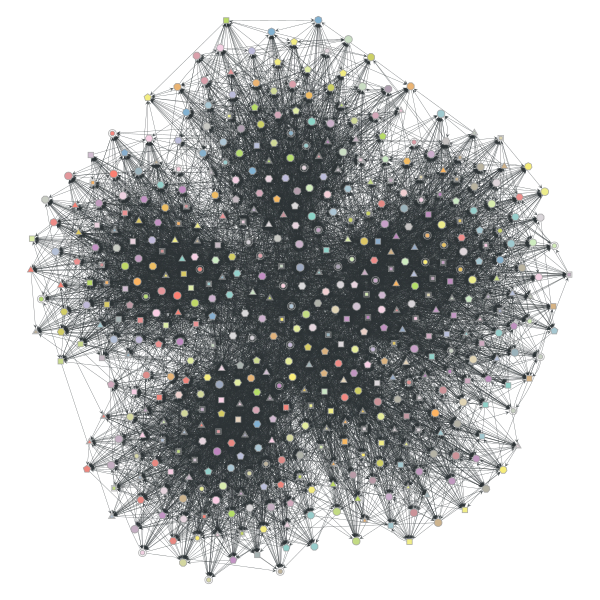

Overall entropy: [inf, 225581.3088682805, inf]
Number of blocks: [[], 250, []]

Merging down blocks from 250 to 125
Beginning nodal updates
Itr: 0, number of nodal moves: 98, delta S: -0.01001
Itr: 1, number of nodal moves: 82, delta S: -0.00489
Itr: 2, number of nodal moves: 86, delta S: -0.00466
Itr: 3, number of nodal moves: 66, delta S: -0.00291
Itr: 4, number of nodal moves: 58, delta S: -0.00177
Itr: 5, number of nodal moves: 48, delta S: -0.00137
Itr: 6, number of nodal moves: 42, delta S: -0.00063
Itr: 7, number of nodal moves: 42, delta S: -0.00109
Itr: 8, number of nodal moves: 45, delta S: -0.00069
Itr: 9, number of nodal moves: 35, delta S: -0.00059
Itr: 10, number of nodal moves: 34, delta S: -0.00055
Itr: 11, number of nodal moves: 31, delta S: -0.00065
Itr: 12, number of nodal moves: 21, delta S: -0.00016
Itr: 13, number of nodal moves: 28, delta S: -0.00046
Total number of nodal moves: 716, overall_entropy: 115620.55


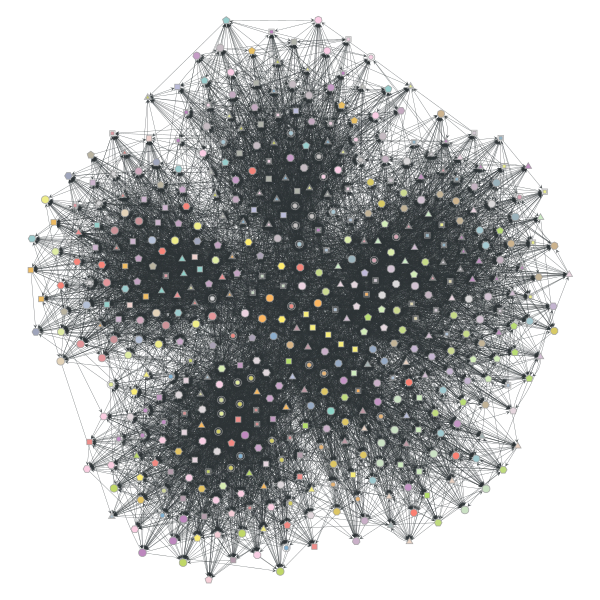

Overall entropy: [225581.3088682805, 115620.55234037191, inf]
Number of blocks: [250, 125, []]

Merging down blocks from 125 to 63
Beginning nodal updates
Itr: 0, number of nodal moves: 60, delta S: -0.00110
Itr: 1, number of nodal moves: 65, delta S: -0.00232
Itr: 2, number of nodal moves: 60, delta S: -0.00110
Itr: 3, number of nodal moves: 51, delta S: -0.00069
Itr: 4, number of nodal moves: 43, delta S: -0.00064
Itr: 5, number of nodal moves: 39, delta S: -0.00057
Itr: 6, number of nodal moves: 33, delta S: -0.00049
Itr: 7, number of nodal moves: 26, delta S: -0.00041
Itr: 8, number of nodal moves: 26, delta S: -0.00023
Total number of nodal moves: 403, overall_entropy: 99576.84


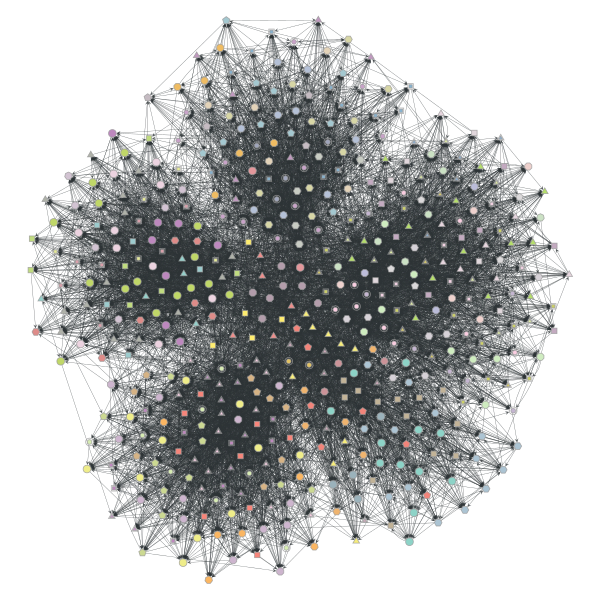

Overall entropy: [115620.55234037191, 99576.838666336873, inf]
Number of blocks: [125, 63, []]

Merging down blocks from 63 to 32
Beginning nodal updates
Itr: 0, number of nodal moves: 47, delta S: -0.00054
Itr: 1, number of nodal moves: 41, delta S: -0.00053
Itr: 2, number of nodal moves: 47, delta S: -0.00074
Itr: 3, number of nodal moves: 37, delta S: -0.00028
Itr: 4, number of nodal moves: 39, delta S: -0.00034
Itr: 5, number of nodal moves: 42, delta S: -0.00040
Total number of nodal moves: 253, overall_entropy: 97327.71


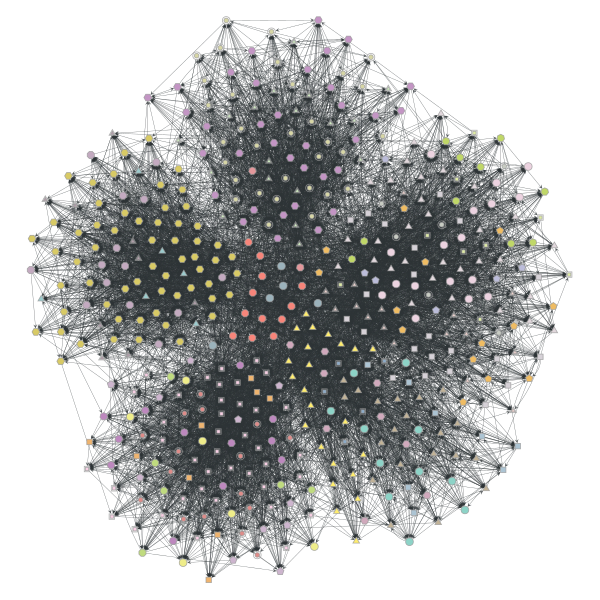

Overall entropy: [99576.838666336873, 97327.713601234063, inf]
Number of blocks: [63, 32, []]

Merging down blocks from 32 to 16
Beginning nodal updates
Itr: 0, number of nodal moves: 41, delta S: -0.00029
Itr: 1, number of nodal moves: 32, delta S: -0.00018
Itr: 2, number of nodal moves: 26, delta S: -0.00016
Total number of nodal moves: 99, overall_entropy: 96802.61


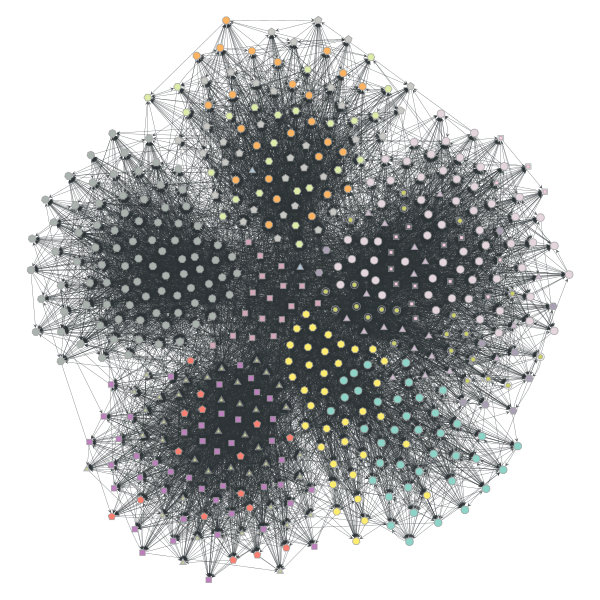

Overall entropy: [97327.713601234063, 96802.614811385516, inf]
Number of blocks: [32, 16, []]

Merging down blocks from 16 to 8
Beginning nodal updates
Itr: 0, number of nodal moves: 0, delta S: 0.00000
Itr: 1, number of nodal moves: 0, delta S: 0.00000
Itr: 2, number of nodal moves: 1, delta S: -0.00028
Total number of nodal moves: 1, overall_entropy: 96490.13


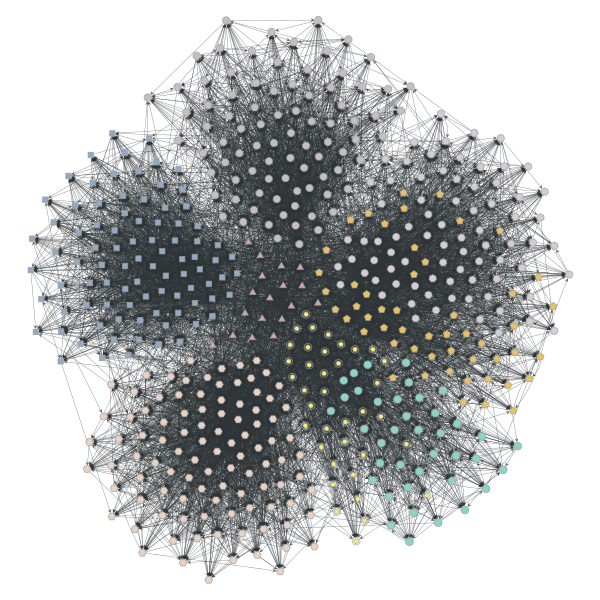

Overall entropy: [96802.614811385516, 96490.134552299627, inf]
Number of blocks: [16, 8, []]

Merging down blocks from 8 to 4
Beginning nodal updates
Itr: 0, number of nodal moves: 0, delta S: 0.00000
Itr: 1, number of nodal moves: 0, delta S: 0.00000
Itr: 2, number of nodal moves: 0, delta S: 0.00000
Total number of nodal moves: 0, overall_entropy: 99165.04


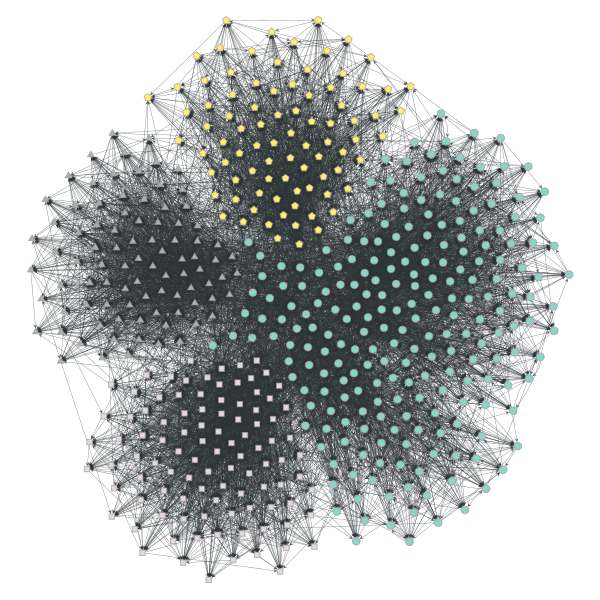

Overall entropy: [96802.614811385516, 96490.134552299627, 99165.042868477336]
Number of blocks: [16, 8, 4]

Merging down blocks from 16 to 13
Beginning nodal updates
Itr: 0, number of nodal moves: 21, delta S: -0.00014
Itr: 1, number of nodal moves: 23, delta S: -0.00010
Itr: 2, number of nodal moves: 14, delta S: -0.00011
Itr: 3, number of nodal moves: 11, delta S: -0.00001
Itr: 4, number of nodal moves: 14, delta S: -0.00007
Total number of nodal moves: 83, overall_entropy: 96669.98


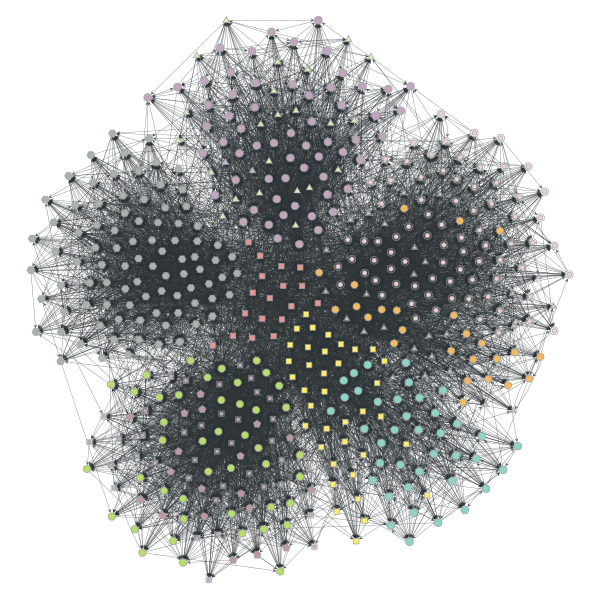

Overall entropy: [96669.977619170022, 96490.134552299627, 99165.042868477336]
Number of blocks: [13, 8, 4]

Merging down blocks from 13 to 11
Beginning nodal updates
Itr: 0, number of nodal moves: 13, delta S: -0.00015
Itr: 1, number of nodal moves: 15, delta S: -0.00002
Itr: 2, number of nodal moves: 17, delta S: -0.00011
Total number of nodal moves: 45, overall_entropy: 96571.05


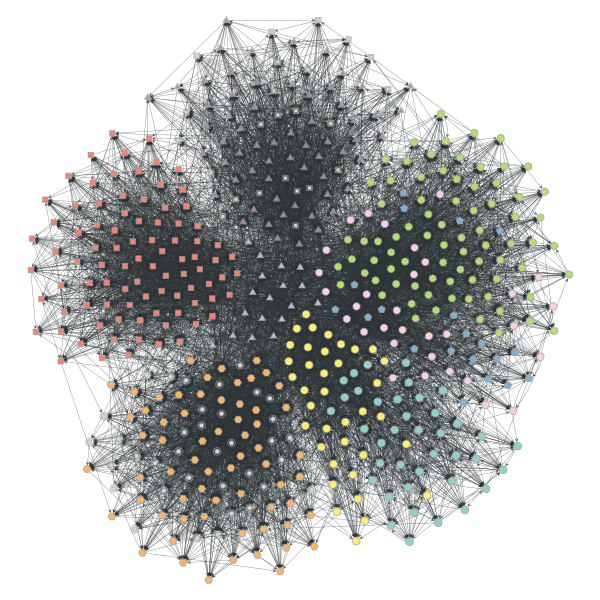

Overall entropy: [96571.051787873235, 96490.134552299627, 99165.042868477336]
Number of blocks: [11, 8, 4]

Merging down blocks from 8 to 6
Beginning nodal updates
Itr: 0, number of nodal moves: 0, delta S: 0.00000
Itr: 1, number of nodal moves: 0, delta S: 0.00000
Itr: 2, number of nodal moves: 0, delta S: 0.00000
Total number of nodal moves: 0, overall_entropy: 97148.88


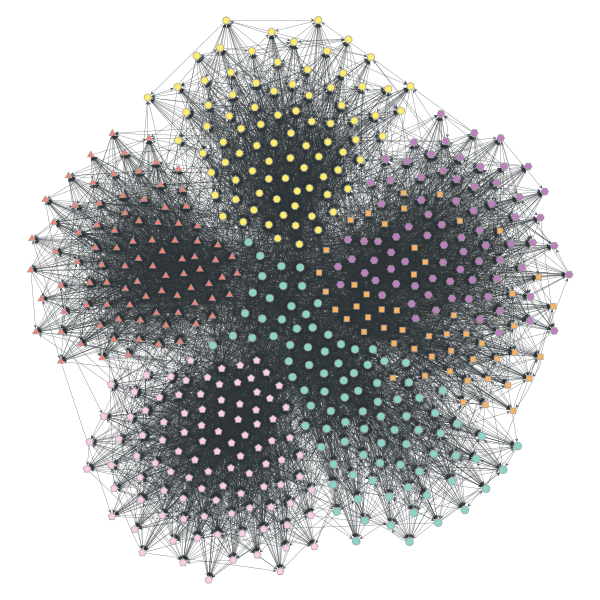

Overall entropy: [96571.051787873235, 96490.134552299627, 97148.882565571388]
Number of blocks: [11, 8, 6]

Merging down blocks from 11 to 10
Beginning nodal updates
Itr: 0, number of nodal moves: 12, delta S: -0.00005
Itr: 1, number of nodal moves: 7, delta S: -0.00005
Itr: 2, number of nodal moves: 11, delta S: -0.00003
Total number of nodal moves: 30, overall_entropy: 96535.42


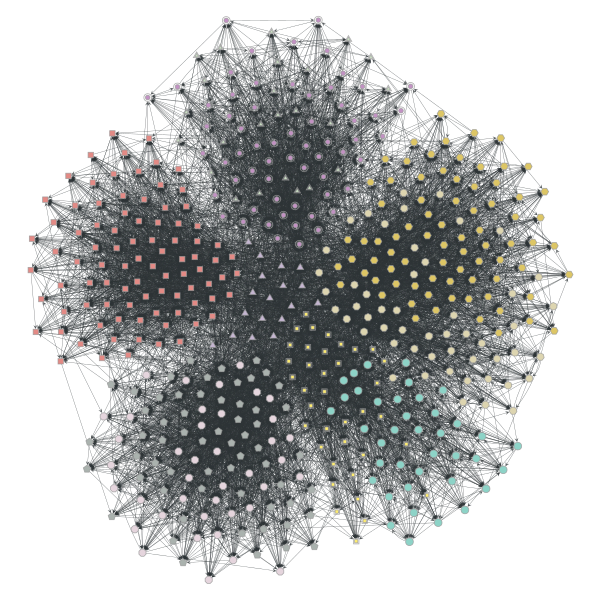

Overall entropy: [96535.417474506321, 96490.134552299627, 97148.882565571388]
Number of blocks: [10, 8, 6]

Merging down blocks from 10 to 9
Beginning nodal updates
Itr: 0, number of nodal moves: 6, delta S: -0.00006
Itr: 1, number of nodal moves: 4, delta S: -0.00006
Itr: 2, number of nodal moves: 4, delta S: -0.00000
Total number of nodal moves: 14, overall_entropy: 96506.22


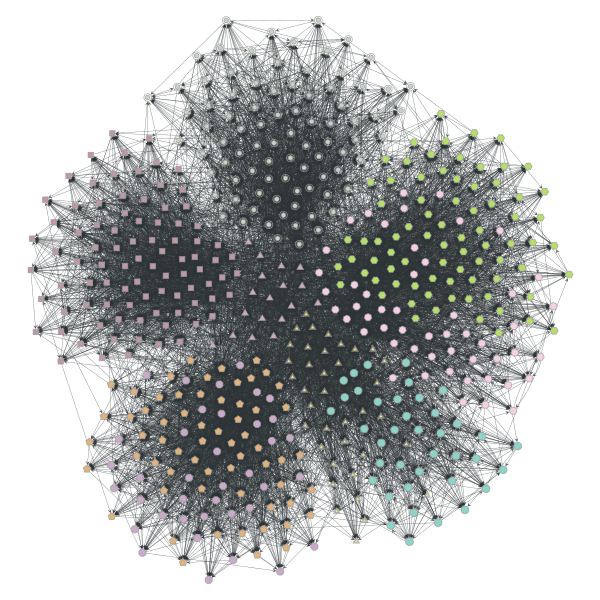

Overall entropy: [96506.221351491666, 96490.134552299627, 97148.882565571388]
Number of blocks: [9, 8, 6]

Merging down blocks from 8 to 7
Beginning nodal updates
Itr: 0, number of nodal moves: 0, delta S: 0.00000
Itr: 1, number of nodal moves: 0, delta S: 0.00000
Itr: 2, number of nodal moves: 0, delta S: 0.00000
Total number of nodal moves: 0, overall_entropy: 96725.31


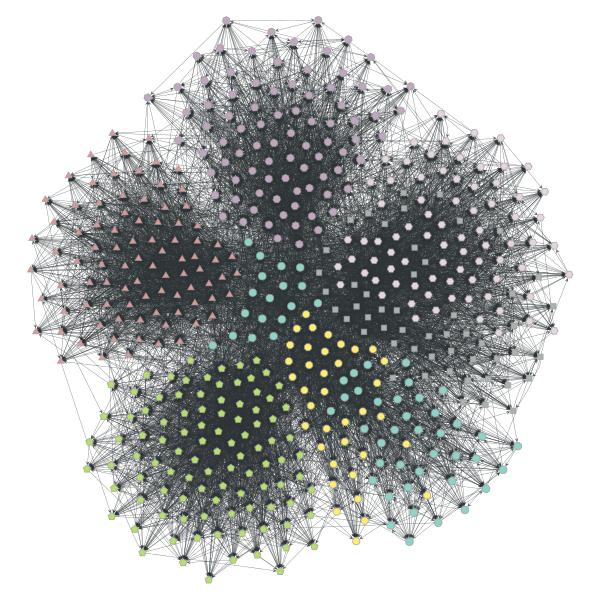

Overall entropy: [96506.221351491666, 96490.134552299627, 96725.314134830624]
Number of blocks: [9, 8, 7]

Optimal partition found with 8 blocks

Graph partition took 56.0963070393 seconds

Partition Correctness Evaluation

Number of nodes: 500
Number of partitions in partition 1: 8
Number of partitions in partition 2: 8
Contingency Table: 
[[  89.    0.    0.    0.    1.    0.    0.    0.]
 [   0.   37.    0.    0.    0.    0.    0.    0.]
 [   0.    0.  100.    0.    0.    0.    0.    0.]
 [   0.    0.    0.   18.    0.    0.    0.    0.]
 [   0.    0.    0.    0.   85.    0.    0.    0.]
 [   0.    0.    0.    0.    0.   79.    0.    0.]
 [   0.    0.    0.    0.    0.    0.   39.    0.]
 [   0.    0.    0.    0.    0.    0.    0.   52.]]
Accuracy (with optimal partition matching): 0.998


Rand Index: 0.998605210421
Adjusted Rand Index: 0.994476007461
Pairwise Recall: 0.995187107939
Pairwise Precision: 0.995402423193


Entropy of partition 1: 1.97003638232
Entropy of partition 2: 1.

In [22]:
input_filename = '../../data/static/simulated_blockmodel_graph_500_nodes'
true_partition_available = True
visualize_graph = True # whether to plot the graph layout colored with intermediate partitions
verbose = True # whether to print updates of the partitioning

out_neighbors, in_neighbors, N, E, true_partition = load_graph(input_filename, true_partition_available)
if verbose:
    print('Number of nodes: {}'.format(N))
    print('Number of edges: {}'.format(E))

if use_timeit:
    t0 = timeit.default_timer()

# initialize by putting each node in its own block (N blocks)
num_blocks = N
partition = np.array(range(num_blocks))

# partition update parameters
beta = 3 # exploitation versus exploration (higher value favors exploitation)
epsilon = sys.float_info.epsilon # small constant for preventing division by and taking log on 0
use_sparse_matrix = False # whether to represent the edge count matrix using sparse matrix 
                          # Scipy's sparse matrix is slow but this may be necessary for large graphs

# agglomerative partition update parameters
num_agg_proposals_per_block = 10 # number of proposals per block
num_block_reduction_rate = 0.5 # fraction of blocks to reduce until the golden ratio bracket is established

# nodal partition updates parameters
max_num_nodal_itr = 100 # maximum number of iterations
delta_entropy_threshold1 = 5e-4 # stop iterating when the change in entropy falls below this fraction of the overall entropy
                                # lowering this threshold results in more nodal update iterations and likely better performance, but longer runtime
delta_entropy_threshold2 = 1e-4 # threshold after the golden ratio bracket is established (typically lower to fine-tune to partition) 
delta_entropy_moving_avg_window = 3 # width of the moving average window for the delta entropy convergence criterion

# initialize edge counts and block degrees
interblock_edge_count, block_degrees_out, block_degrees_in, block_degrees = initialize_edge_counts(out_neighbors, num_blocks, partition, use_sparse_matrix)

# initialize items before iterations to find the partition with the optimal number of blocks
optimal_num_blocks_found, old_partition, old_interblock_edge_count, old_block_degrees, old_block_degrees_out, old_block_degrees_in, old_overall_entropy, old_num_blocks, graph_object = initialize_partition_variables()
num_blocks_to_merge = int(num_blocks*num_block_reduction_rate)

# begin partitioning by finding the best partition with the optimal number of blocks
while not optimal_num_blocks_found:
    # begin agglomerative partition updates (i.e. block merging)
    if verbose:
        print("\nMerging down blocks from {} to {}".format(num_blocks, num_blocks - num_blocks_to_merge))
    best_merge_for_each_block = np.ones(num_blocks, dtype = int)*-1 # initialize to no merge
    delta_entropy_for_each_block = np.ones(num_blocks)*np.Inf # initialize criterion
    block_partition = range(num_blocks)
    for current_block in range(num_blocks): # evalaute agglomerative updates for each block
        for proposal_idx in range(num_agg_proposals_per_block):
            # populate edges to neighboring blocks
            if use_sparse_matrix:
                out_blocks = interblock_edge_count[current_block,:].nonzero()[1]
                out_blocks = np.hstack((out_blocks.reshape([len(out_blocks),1]), interblock_edge_count[current_block,out_blocks].toarray().transpose()))
            else:
                out_blocks = interblock_edge_count[current_block,:].nonzero()
                out_blocks = np.hstack((np.array(out_blocks).transpose(), interblock_edge_count[current_block,out_blocks].transpose()))
            if use_sparse_matrix:
                in_blocks = interblock_edge_count[:,current_block].nonzero()[0]
                in_blocks = np.hstack((in_blocks.reshape([len(in_blocks),1]), interblock_edge_count[in_blocks,current_block].toarray()))
            else:
                in_blocks = interblock_edge_count[:,current_block].nonzero()
                in_blocks = np.hstack((np.array(in_blocks).transpose(), interblock_edge_count[in_blocks,current_block].transpose()))

            # propose a new block to merge with
            proposal, num_out_neighbor_edges, num_in_neighbor_edges, num_neighbor_edges = propose_new_partition(current_block, out_blocks, in_blocks, block_partition, interblock_edge_count, block_degrees, num_blocks, 1, use_sparse_matrix)

            # compute the two new rows and columns of the interblock edge count matrix
            new_interblock_edge_count_current_block_row, new_interblock_edge_count_new_block_row, new_interblock_edge_count_current_block_col, new_interblock_edge_count_new_block_col = \
                compute_new_rows_cols_interblock_edge_count_matrix(interblock_edge_count, current_block, proposal, out_blocks[:,0], out_blocks[:,1], in_blocks[:,0], in_blocks[:,1], interblock_edge_count[current_block, current_block], 1, use_sparse_matrix)    

            # compute new block degrees           
            block_degrees_out_new, block_degrees_in_new, block_degrees_new = compute_new_block_degrees(current_block, proposal, block_degrees_out, block_degrees_in, block_degrees, num_out_neighbor_edges, num_in_neighbor_edges, num_neighbor_edges)

            # compute change in entropy / posterior
            delta_entropy = compute_delta_entropy(current_block, proposal, out_blocks[:,0], in_blocks[:,0], interblock_edge_count, new_interblock_edge_count_current_block_row, new_interblock_edge_count_new_block_row, new_interblock_edge_count_current_block_col, new_interblock_edge_count_new_block_col, block_degrees_out, block_degrees_in, block_degrees_out_new, block_degrees_in_new, epsilon, use_sparse_matrix)
            if delta_entropy < delta_entropy_for_each_block[current_block]: # a better block candidate was found
                best_merge_for_each_block[current_block] = proposal
                delta_entropy_for_each_block[current_block] = delta_entropy

    # carry out the best merges
    partition, num_blocks = carry_out_best_merges(delta_entropy_for_each_block, best_merge_for_each_block, partition, num_blocks, num_blocks_to_merge)

    # re-initialize edge counts and block degrees
    interblock_edge_count, block_degrees_out, block_degrees_in, block_degrees = initialize_edge_counts(out_neighbors, num_blocks, partition, use_sparse_matrix)
    
    # perform nodal partition updates
    if verbose:
        print("Beginning nodal updates")
    total_num_nodal_moves = 0            
    itr_delta_entropy = np.zeros(max_num_nodal_itr)

    # compute the global entropy for MCMC convergence criterion
    overall_entropy = compute_overall_entropy(interblock_edge_count, block_degrees_out, block_degrees_in, num_blocks, N, E, use_sparse_matrix)

    for itr in range(max_num_nodal_itr):
        num_nodal_moves = 0;
        itr_delta_entropy[itr] = 0

        for current_node in range(N):
            current_block = partition[current_node] 
            # propose a new block for this node
            proposal, num_out_neighbor_edges, num_in_neighbor_edges, num_neighbor_edges = propose_new_partition(current_block, out_neighbors[current_node], in_neighbors[current_node], partition, interblock_edge_count, block_degrees, num_blocks, 0, use_sparse_matrix)

            # determine whether to accept or reject the proposal
            if (proposal != current_block):
                # compute block counts of in and out neighbors
                blocks_out, inverse_idx_out = np.unique(partition[out_neighbors[current_node][:,0]], return_inverse = True)
                count_out = np.bincount(inverse_idx_out, weights=out_neighbors[current_node][:,1]).astype(int)
                blocks_in, inverse_idx_in = np.unique(partition[in_neighbors[current_node][:,0]], return_inverse = True)
                count_in = np.bincount(inverse_idx_in, weights=in_neighbors[current_node][:,1]).astype(int)

                # compute the two new rows and columns of the interblock edge count matrix
                self_edge_weight = np.sum(out_neighbors[current_node][np.where(out_neighbors[current_node][:,0]==current_node),1]) # check if this node has a self edge
                new_interblock_edge_count_current_block_row, new_interblock_edge_count_new_block_row, new_interblock_edge_count_current_block_col, new_interblock_edge_count_new_block_col = \
                    compute_new_rows_cols_interblock_edge_count_matrix(interblock_edge_count, current_block, proposal, blocks_out, count_out, blocks_in, count_in, self_edge_weight, 0, use_sparse_matrix)

                # compute new block degrees           
                block_degrees_out_new, block_degrees_in_new, block_degrees_new = compute_new_block_degrees(current_block, proposal, block_degrees_out, block_degrees_in, block_degrees, num_out_neighbor_edges, num_in_neighbor_edges, num_neighbor_edges)

                # compute the Hastings correction
                Hastings_correction = compute_Hastings_correction(blocks_out, count_out, blocks_in, count_in, proposal, interblock_edge_count, new_interblock_edge_count_current_block_row, new_interblock_edge_count_current_block_col, num_blocks, num_neighbor_edges, block_degrees, block_degrees_new, use_sparse_matrix)

                # compute change in entropy / posterior
                delta_entropy = compute_delta_entropy(current_block, proposal, blocks_out, blocks_in, interblock_edge_count, new_interblock_edge_count_current_block_row, new_interblock_edge_count_new_block_row, new_interblock_edge_count_current_block_col, new_interblock_edge_count_new_block_col, block_degrees_out, block_degrees_in, block_degrees_out_new, block_degrees_in_new, epsilon, use_sparse_matrix)

                # compute probability of acceptance
                p_accept = np.min([np.exp(-beta*delta_entropy)*Hastings_correction, 1])

                # if accept the proposal, update the partition, inter_block_edge_count, and block degrees
                if (np.random.uniform() <= p_accept):
                    total_num_nodal_moves += 1
                    num_nodal_moves += 1
                    itr_delta_entropy[itr] += delta_entropy
                    partition, interblock_edge_count, block_degrees_out, block_degrees_in, block_degrees = update_partition(partition, current_node, current_block, proposal, interblock_edge_count, new_interblock_edge_count_current_block_row, new_interblock_edge_count_new_block_row, new_interblock_edge_count_current_block_col, new_interblock_edge_count_new_block_col, block_degrees_out_new, block_degrees_in_new, block_degrees_new, use_sparse_matrix)
        if verbose:
            print("Itr: {}, number of nodal moves: {}, delta S: {:0.5f}".format(itr, num_nodal_moves, itr_delta_entropy[itr]/float(overall_entropy)))
        if itr>=(delta_entropy_moving_avg_window-1): # exit MCMC if the recent change in entropy falls below a small fraction of the overall entropy
            if not(np.all(np.isfinite(old_overall_entropy))): # golden ratio bracket not yet established 
                if (-np.mean(itr_delta_entropy[(itr-delta_entropy_moving_avg_window+1):itr]) < (delta_entropy_threshold1*overall_entropy)):
                    break
            else: # golden ratio bracket is established. Fine-tuning partition.
                if (-np.mean(itr_delta_entropy[(itr-delta_entropy_moving_avg_window+1):itr]) < (delta_entropy_threshold2*overall_entropy)):
                    break

    # compute the global entropy for determining the optimal number of blocks
    overall_entropy = compute_overall_entropy(interblock_edge_count, block_degrees_out, block_degrees_in, num_blocks, N, E, use_sparse_matrix)

    if verbose:
        print("Total number of nodal moves: {}, overall_entropy: {:0.2f}".format(total_num_nodal_moves, overall_entropy))
    if visualize_graph:
        graph_object = plot_graph_with_partition(out_neighbors, partition, graph_object)

    # check whether the partition with optimal number of block has been found; if not, determine and prepare for the next number of blocks to try
    partition, interblock_edge_count, block_degrees, block_degrees_out, block_degrees_in, num_blocks, num_blocks_to_merge, old_partition, old_interblock_edge_count, old_block_degrees, old_block_degrees_out, old_block_degrees_in, old_overall_entropy, old_num_blocks, optimal_num_blocks_found = \
        prepare_for_partition_on_next_num_blocks(overall_entropy, partition, interblock_edge_count, block_degrees, block_degrees_out, block_degrees_in, num_blocks, old_partition, old_interblock_edge_count, old_block_degrees, old_block_degrees_out, old_block_degrees_in, old_overall_entropy, old_num_blocks, num_block_reduction_rate)

    if verbose:
        print('Overall entropy: {}'.format(old_overall_entropy))
        print('Number of blocks: {}'.format(old_num_blocks))
        if optimal_num_blocks_found:
            print('\nOptimal partition found with {} blocks'.format(num_blocks))
if use_timeit:
    t1 = timeit.default_timer()
    print('\nGraph partition took {} seconds'.format(t1-t0))

# evaluate output partition against the true partition
evaluate_partition(true_partition, partition)
    